# **Proyecto: 🌍✈️ Sistema integrado de gestión y recomendación de viajes**
### **Materia:** Base de Datos 2025
## Alumno: Delfina González

Este trabajo simula la integración de datos diferentes bases de datos para modelar un sistema de gestión y recomendación de viajes. El sistema **almacena** datos de usuarios, destinos, hoteles, actividades, y realiza **recomendaciones** personalizadas a partir de datos distribuidos en **Neo4j, MongoDB y Redis.**

*En el mundo actual, los viajes y el turismo generan grandes cantidades de información sobre usuarios, destinos, alojamientos y actividades. Las empresas turísticas necesitan sistemas que no solo registren esta información, sino que también permitan realizar análisis, recomendaciones personalizadas y gestionar reservas de manera eficiente.*

### Funcionalidades:
 - Almacenar información de usuarios,  historial de reservas, destinos turísticos, hoteles, actividades disponibles y precios asociados. 👉 MongoDB 
 - Gestionar datos temporales como usuarios conectados o reservas en proceso. 👉 Redis
 - Relaciones de conocimiento entre usuarios, relaciones de usuarios y destinos (visitas). 👉 Neo4j.

### ⚙️ Elección y ventajas de las bases de datos utilizadas

El sistema combina **tres tecnologías de bases de datos complementarias**, cada una seleccionada por sus fortalezas específicas frente al tipo de información que maneja.

#### 🟢 MongoDB — Datos estructurados y semiestructurados
- **Ventaja principal:** Persistencia y flexibilidad en el manejo de documentos JSON, ideal para almacenar estructuras heterogéneas como usuarios, reservas, destinos o actividades.  
- **Permite** escalabilidad horizontal, consultas ágiles y fácil integración con aplicaciones en Python.  
- **Justificación:** los datos de usuarios y destinos poseen diferentes atributos y jerarquías, lo que hace más eficiente su almacenamiento en una base **NoSQL orientada a documentos**.

#### 🔴 Redis — Datos temporales y de alta frecuencia
- **Ventaja principal:** Al ser una base **en memoria**, ofrece una **velocidad de acceso extremadamente alta**, ideal para sesiones activas y procesos en tiempo real.  
- **Permite** gestionar usuarios conectados y caché de reservas pendientes, datos sin necesidad de almacenamiento estable y a largo plazo.  
- **Justificación:** su estructura tipo *key-value* simplifica la gestión de información volátil y evita sobrecargar las bases persistentes.

#### 🔵 Neo4j — Relaciones y conocimiento
- **Ventaja principal:** Modelo de datos **basado en grafos**, óptimo para representar y consultar relaciones complejas (como amistades o vínculos entre usuarios y destinos).  
- **Permite** ejecutar consultas semánticas eficientes mediante el lenguaje **Cypher**, identificando patrones y rutas dentro del grafo.  
- **Justificación:** el análisis de relaciones (por ejemplo, recomendaciones basadas en amigos o destinos visitados) requiere un modelo relacional dinámico y navegable, que Neo4j resuelve de forma más natural y eficiente que una base tabular.

➡️ En conjunto, esta arquitectura **poliglota** permite aprovechar lo mejor de cada tecnología:  
MongoDB para persistencia flexible, Redis para velocidad en operaciones temporales y Neo4j para análisis de relaciones y recomendaciones.


### Estructura del proyecto:

    - PARTE 0: "Configuración y conexiones"
    - PARTE A: "Carga inicial de Datasets"
    - PARTE B: "Consultas"
    - PARTE C: "Estadísticas y Gráficos"
    - PARTE D: "Modificaciones"
    - PARTE F: "Cierre de sesiones"

# PARTE 0: Configuración y conexiones

### 🧩 Importación de librerías

En este bloque se importan las librerías necesarias para todo el proyecto:  
- `os`, `time`, `dotenv`, `json` y `random` para tareas generales del sistema y manejo de datos.  
- `pandas` para manipulación tabular.  
- `matplotlib.pyplot` para generar visualizaciones.
- `neo4j`, `redis`, `pymongo`, para la conexión a cada base.
- Otras como: `IPython.display`, `datetime` y `numpy` se usaron en las consultas y gráficos.

👉 Esta sección prepara el entorno de trabajo para las etapas posteriores de carga, procesamiento y visualización de datos.

    Se cargan las bibliotecas
    Se establecen las conexiones con Neo4j, MongoDB y Redis.

In [ ]:
import os, time
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from dotenv import load_dotenv
from neo4j import GraphDatabase
from pymongo import MongoClient
import redis
from datetime import datetime
import numpy as np

# --- Configuración ---
load_dotenv()
print("Esperando servicios (5s)...")
time.sleep(5)

NEO4J_HOST = "bolt://neo4j:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")
MONGO_URI = f"mongodb://{os.getenv('MONGO_INITDB_ROOT_USERNAME', 'admin')}:{os.getenv('MONGO_INITDB_ROOT_PASSWORD', 'admin123')}@mongo:27017/"
REDIS_HOST = os.getenv("REDIS_HOST", "redis")
REDIS_PORT = int(os.getenv("REDIS_PORT", 6379))
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "redis123")

print("Variables cargadas y hosts definidos.")

# --- Conexiones ---
def connect_neo4j():
    try:
        driver = GraphDatabase.driver(NEO4J_HOST, auth=(NEO4J_USER, NEO4J_PASSWORD))
        with driver.session() as s:
            s.run("RETURN 1")
        print("✅ Conectado a Neo4j")
        return driver
    except Exception as e:
        print(f"❌ Error al conectar a Neo4j: {e}")
        return None

def connect_mongo():
    try:
        client = MongoClient(MONGO_URI)
        client.server_info()
        print("✅ Conectado a MongoDB")
        return client
    except Exception as e:
        print(f"❌ Error al conectar a MongoDB: {e}")
        return None

def connect_redis():
    try:
        r = redis.Redis(
            host=REDIS_HOST,
            port=REDIS_PORT,
            password=REDIS_PASSWORD,
            decode_responses=True
        )
        r.ping()
        print("✅ Conectado a Redis")
        return r
    except Exception as e:
        print(f"❌ Error al conectar a Redis: {e}.")
        return None

neo4j_driver = connect_neo4j()
mongo_client = connect_mongo()
redis_client = connect_redis()

DB_NAME = "base_proyecto"
db = mongo_client[DB_NAME] if mongo_client else None

# Cargo constantes
DESTINO_ID_A_CIUDAD = {
    1: "Bariloche",
    2: "Cancún",
    3: "Madrid",
    4: "Roma",
    5: "Mendoza",
    6: "Ushuaia",
    7: "Puerto Iguazú",
    8: "Salta",
    9: "Río de Janeiro",
    10: "Punta Cana",
    11: "El Calafate",
    12: "Santiago",
    13: "Nueva York",
    14: "Tucumán",
    15: "Mar del Plata",
    16: "San Salvador de Jujuy"
}

CIUDAD_A_DESTINO_ID = {v: k for k, v in DESTINO_ID_A_CIUDAD.items()}

Esperando servicios (5s)...
Variables cargadas y hosts definidos.
✅ Conectado a Neo4j
✅ Conectado a MongoDB
✅ Conectado a Redis


# PARTE A: Carga inicial de Datasets

## 1. Carga de Datos Base y Limpieza
    Se cargan los datos de los archivos JSON requeridos y se limpian las bases de datos.

### 🗂️ Configuración de archivos de datos

Aquí se definen las rutas y los archivos requeridos por el sistema (usuarios, destinos, hoteles, actividades y reservas).  
También se inicializan estructuras (`data`, `missing`) para verificar si todos los archivos están disponibles.

Se asegura la limpieza de las bases para mantener la integridad de los datos en cada ejecución

👉 Esta verificación inicial evita errores en etapas posteriores al asegurar que la base de datos cuente con todos los insumos.


In [659]:
DATA_DIR = "data"
required_files = ["usuarios.json", "destinos.json", "hoteles.json", "actividades.json", "reservas.json"]
data = {}
missing = []

for f_name in required_files:
    f_path = os.path.join(DATA_DIR, f_name)
    if os.path.exists(f_path):
        with open(f_path, encoding="utf-8") as f:
            data[f_name.split('.')[0]] = json.load(f)
    else:
        missing.append(f_name)

if missing:
    print(f"⚠️ No se encontraron los siguientes archivos en '{DATA_DIR}/': {', '.join(missing)}")
    print("Por favor, asegúrate de tener todos los archivos JSON necesarios.")
else:
    print("✅ Archivos de datos cargados correctamente.")
    print("-" * 30)

# --- Limpieza de Bases de Datos ---
if neo4j_driver:
    with neo4j_driver.session() as s:
        s.run("MATCH (n) DETACH DELETE n")
        print("✅ Neo4j limpio.")

if mongo_client:
    mongo_client.drop_database(DB_NAME)
    print(f"✅ MongoDB ({DB_NAME}) limpio.")

if redis_client:
    for key in redis_client.scan_iter("tp_*"): 
        redis_client.delete(key)
    print("✅ Claves temporales de Redis limpias.")


✅ Archivos de datos cargados correctamente.
------------------------------
✅ Neo4j limpio.
✅ MongoDB (base_proyecto) limpio.
✅ Claves temporales de Redis limpias.


## 2. Carga en MongoDB, Redis y Neo4j
### Distribución de datos:

    - **MongoDB:** Usuarios, Destinos, Hoteles, Actividades y Reservas Concretadas.
    - **Redis:** Reservas Pendientes (temporal) y Usuarios Conectados (set).
    - **Neo4j:** Nodos (Usuarios, Destinos) y Relaciones (Amigos y Familiares)

### 💾 Carga de datos estables y dinámicos

En este bloque se realiza la carga de los datos en la base MongoDB.  
Se insertan colecciones separadas (`usuarios`, `destinos`, `hoteles`, `actividades`,`reservas`) desde los archivos JSON previamente validados.

Luego, se generan los datos temporales de `conexión de usuarios` y `reservas pendientes` de forma aleatoria para cargarlos en Redis.

Por último, se crean los `nodos` que utilizaremos para las relaciones de Neo4j (`usuarios` y `destinos`), las `relaciones sociales(amigos/familia)` y las `visitas` con un algotirmo aleatorio pero coherente y basado en los Datasets disponibles.

👉 Esta etapa constituye la **persistencia de datos**: garantiza que la información quede almacenada en la base para las consultas posteriores.


In [660]:
if data:
    # Carga en MongoDB (Datos permanentes)
    db.usuarios.insert_many(data["usuarios"])
    db.destinos.insert_many(data["destinos"])
    db.hoteles.insert_many(data["hoteles"])
    db.actividades.insert_many(data["actividades"])
    
    # Filtrar Reservas: Cargo solo las que tienen estado CONFIRMADO a MongoDB
    reservas_concretadas = [
        r for r in data["reservas"] 
        if r["estado"] == "Confirmada"
    ]
    if reservas_concretadas:
        db.reservas.insert_many(reservas_concretadas)
    
    print("✅ Datos base y Reservas concretadas cargados en MongoDB.")

    # Carga en Redis (Datos temporales: Caché y Reservas Pendientes)
    if redis_client:
        redis_client.delete("viajes_usuarios_conectados")
        redis_client.delete("viajes_cache:busquedas")
        # Reservas Temporales (Pendientes). Se crea un hash por reserva pendiente con expiración aleatoria entre 30 y 120 segundos.
        reservas_pendientes = [
            r for r in data["reservas"] 
            if r["estado"] == "Pendiente"
        ]
        for r in reservas_pendientes:
            clave_pend = f"viajes_reserva:pendiente:{r['reserva_id']}"
            r_str = {k: str(v) for k, v in r.items()}
            redis_client.hset(clave_pend, mapping=r_str)
            redis_client.expire(clave_pend, random.randint(30, 120))
        print(f"✅ {len(reservas_pendientes)} Reservas Pendientes cargadas en Redis.")

        # Usuarios Conectados. Se crea un set con entre 5 y 25 usuarios aleatorios.
        usuarios_conectados = random.sample([usu["nombre"] for usu in data["usuarios"]], k=random.randint(5, 25))
        for nombre in usuarios_conectados:
            redis_client.sadd("viajes_usuarios_conectados", nombre)
        print(f"✅ {len(usuarios_conectados)} Usuarios Conectados cargados en Redis.")

    # --- 3️⃣ Búsquedas en Caché (hashes con expiración ampliadas) ---

        # Ciudades, países y tipos disponibles desde los datos
        ciudades_populares = [d["ciudad"] for d in data["destinos"]]
        paises_populares = sorted(set([d["pais"] for d in data["destinos"]]))
        tipos_populares = sorted(set([d["tipo"] for d in data["destinos"]]))

        # Búsquedas simuladas
        num_busquedas = random.randint(10, 40)

        # Generar búsquedas mixtas (ciudad, país, tipo o precio)
        opciones_busqueda = []

        for _ in range(num_busquedas):
            tipo_busqueda = random.choice(["ciudad", "pais", "tipo", "precio"])
            
            if tipo_busqueda == "ciudad":
                valor = random.choice(ciudades_populares)
                clave_cache = f"viajes_cache:busqueda:ciudad:{valor.lower()}"
                
            elif tipo_busqueda == "pais":
                valor = random.choice(paises_populares)
                clave_cache = f"viajes_cache:busqueda:pais:{valor.lower().replace(' ', '_')}"
                
            elif tipo_busqueda == "tipo":
                valor = random.choice(tipos_populares)
                clave_cache = f"viajes_cache:busqueda:tipo:{valor.lower()}"
                
            # Simular datos asociados a la búsqueda
            busqueda_data = {
                "tipo_busqueda": tipo_busqueda,
                "valor": valor,
                "timestamp": datetime.now().isoformat(timespec="seconds"),
                "resultados_encontrados": str(random.randint(1, 5))
            }

            redis_client.hset(clave_cache, mapping=busqueda_data)
            redis_client.expire(clave_cache, random.randint(90, 360))

        print(f"✅ {num_busquedas} búsquedas mixtas (ciudad, país, tipo) cargadas en caché Redis.")

    # Carga en Neo4j (Nodos y Relaciones)
    # Nodos 
    if neo4j_driver:
        with neo4j_driver.session() as s:
            # Restricciones de unicidad, para asegurar la integridad y consistencia de los datos
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (u:Usuario) REQUIRE u.usuario_id IS UNIQUE")
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Destino) REQUIRE d.destino_id IS UNIQUE")

            # Nodos: Usuario y Destino. 
            for u in data["usuarios"]:
                s.run("MERGE (u:Usuario {usuario_id:$id, nombre:$nombre})", id=u["usuario_id"], nombre=u["nombre"])
            for d in data["destinos"]:
                s.run("MERGE (d:Destino {destino_id: $id}) SET d.ciudad = $ciudad, d.precio_base = $precio_base", 
                      id=d["destino_id"], ciudad=d["ciudad"], precio_base=d["precio_base"])

    # Relaciones VISITÓ basadas en Reservas Confirmadas Pasadas
    hoy = datetime.now().date()
    reservas_validas = [
        r for r in data.get("reservas", [])
        if r.get("estado") == "Confirmada" and datetime.strptime(r["fecha_reserva"], "%Y-%m-%d").date() <= hoy
        ]
  
    with neo4j_driver.session() as s:
        if reservas_validas not in (None, []):
            for r in reservas_validas:
                u_id = r["usuario_id"]
                d_id = r["destino_id"]
                s.run(
                        """
                        MATCH (u:Usuario {usuario_id:$u}), (d:Destino {destino_id:$d})
                        MERGE (u)-[:VISITO]->(d)
                        """,
                        u=u_id, d=d_id  
                    )
            print(f"✅ {len(reservas_validas)} relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.")
            # Mostrar las reservas válidas en un DataFrame
            df_visito = pd.DataFrame(reservas_validas)
            df_visito['Nombre Usuario'] = df_visito['usuario_id'].map({u["usuario_id"]: u["nombre"] for u in data["usuarios"]})
            df_visito['Ciudad Destino'] = df_visito['destino_id'].map(DESTINO_ID_A_CIUDAD)
            display(df_visito[["reserva_id", "fecha_reserva", "estado", "Nombre Usuario", "Ciudad Destino"]].sort_values("Nombre Usuario"))
        else:
            print("⚠️ No hay reservas confirmadas pasadas para crear relaciones VISITÓ.")

        # Relaciones Sociales (AMIGO_DE, FAMILIAR_DE) - Evitando duplicados e inversas
        tipos_relacion = ["AMIGO_DE", "FAMILIAR_DE"] 
            
        # Intentamos crear el triple de relaciones que usuarios de forma aleatoria
        # Se evita crear relaciones entre el mismo usuario y ya existentes (ej. amigo y familiar a la vez)
        relaciones_creadas = []

        for _ in range(len(data["usuarios"]) * 3):
                u1 = random.choice(data["usuarios"])
                u2 = random.choice(data["usuarios"])
                u1_id = u1["usuario_id"]
                u2_id = u2["usuario_id"]
                tipo = random.choice(tipos_relacion)

                # 1. Aseguramos que los IDs sean diferentes.
                if u1_id == u2_id:
                    continue
               
                query = f"""
                MATCH (u1:Usuario {{usuario_id: $u1_id}})
                MATCH (u2:Usuario {{usuario_id: $u2_id}})

                WHERE NOT (u1)-[:AMIGO_DE|FAMILIAR_DE]-(u2)
                
                MERGE (u1)-[:{tipo}]->(u2)
                """
                # Ejecutar la query con los parámetros
                resultado_relaciones = s.run(query, u1_id=u1_id, u2_id=u2_id)

                if resultado_relaciones is not None:
                # Almacenar los datos de la relación *creada*
                    relaciones_creadas.append({
                        "Usuario 1": u1["nombre"],
                        "Usuario 2": u2["nombre"],
                        "Tipo de Relación": tipo
                    })
        # Asegurar bidireccionalidad para AMIGO_DE (si A es amigo de B, entonces B es amigo de A)
        query_bidireccional = """
            MATCH (a:Usuario)-[:AMIGO_DE]->(b:Usuario)
            WHERE NOT (b)-[:AMIGO_DE]->(a)
            MERGE (b)-[:AMIGO_DE]->(a)
            RETURN COUNT(*) AS relaciones_creadas
            """

        try:
            result = s.run(query_bidireccional).single()
            cantidad_creadas = result["relaciones_creadas"] if result else 0
        except Exception as e:
            print("⚠️ Error al asegurar bidireccionalidad:", e)

        df_relaciones = pd.DataFrame(relaciones_creadas)

        print(f"✅ {df_relaciones.shape[0]} Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.")

        pd.set_option('display.max_rows', 100)
        pd.set_option('display.max_colwidth', 500)

        display(df_relaciones.sort_values(["Tipo de Relación", "Usuario 1"]).reset_index(drop=True))

✅ Datos base y Reservas concretadas cargados en MongoDB.
✅ 13 Reservas Pendientes cargadas en Redis.
✅ 11 Usuarios Conectados cargados en Redis.
✅ 12 búsquedas mixtas (ciudad, país, tipo) cargadas en caché Redis.
✅ 29 relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.


,reserva_id,fecha_reserva,estado,Nombre Usuario,Ciudad Destino
28,50,2025-04-20,Confirmada,Agustina Benítez,Río de Janeiro
15,25,2025-03-01,Confirmada,Agustina Benítez,Tucumán
2,5,2024-06-25,Confirmada,Ana Torres,Mendoza
12,18,2024-08-25,Confirmada,Andrés Pereyra,Puerto Iguazú
26,47,2025-01-25,Confirmada,Bárbara Nuñez,Ushuaia
24,41,2025-07-15,Confirmada,Carla Gómez,Bariloche
18,31,2025-09-10,Confirmada,Delfina Giménez,Mendoza
11,17,2024-07-20,Confirmada,Diego Romero,Ushuaia
8,11,2024-01-01,Confirmada,Emilia Ríos,Bariloche
19,32,2025-10-15,Confirmada,Ezequiel Blanco,Ushuaia


✅ 147 Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.


,Usuario 1,Usuario 2,Tipo de Relación
0,Agustina Benítez,Sofia Olmos,AMIGO_DE
1,Agustina Benítez,Osvaldo Quintana,AMIGO_DE
2,Ana Torres,Sofía Morales,AMIGO_DE
3,Andrés Pereyra,Sofía Morales,AMIGO_DE
4,Camilo Arias,Carlos Colapinto,AMIGO_DE
...,...,...,...
142,Sofia Olmos,Quimey Benítez,FAMILIAR_DE
143,Sofia Olmos,Javier Rivas,FAMILIAR_DE
144,Sofia Olmos,Milagros Herrera,FAMILIAR_DE
145,Valentina Gil,Lucía Godoy,FAMILIAR_DE


# PARTE B: Consultas

### Definición de las funciones *helper* y las consultas específicas para cada base de datos.

### ⚙️ Funciones auxiliares para consultas

Se definen funciones genéricas que ejecutan consultas sobre Neo4j y devuelven los resultados en formato de lista o DataFrame.  
Estas funciones centralizan la conexión y el manejo de errores, facilitando la reutilización en distintos análisis.

Se incluyen los procesamientos de los datos para cada consulta, con el objetivo de luego poder tener una visualización de los resultados más limpia y ordenada.

👉 Esta decisión mejora la **modularidad y mantenibilidad** del código, al concentrar la lógica de conexión y consulta en un solo lugar.


In [661]:
# --- FUNCIONES DE AUXILIARES PARA LAS CONSULTAS -----------------------------------------------
def query_neo4j(query, params=None):
    """Ejecuta una consulta en Neo4j y devuelve lista de diccionarios."""
    if not neo4j_driver:
        return []

    with neo4j_driver.session() as s:
        try:
            result = s.run(query, **(params or {}))
            # Convertir cada registro en dict (para Pandas)
            return [dict(r) for r in result]
        except Exception as e:
            print("⚠️ Error en query_neo4j:", e)
            return []

def query_mongo(collection_name, query):
    """Función helper para ejecutar consultas en MongoDB. Devuelve lista de documentos."""
    
    if db is None: 
        return []
        
    return list(db[collection_name].find(query))

def query_redis(pattern):
    """
    Consulta Redis según un patrón y devuelve datos listos para pandas.
    Compatible con hashes (reservas) y sets (usuarios conectados).
    Devuelve una lista de diccionarios.
    """
    if redis_client is None:
        print("⚠️ Redis no está conectado.")
        return []

    results = []

    try:
        keys = redis_client.keys(pattern)

        for key in keys:
            tipo = redis_client.type(key)

            if tipo == "hash":
                data = redis_client.hgetall(key)
                results.append(data)
            elif tipo == "set":
                # Convertimos en una lista de usuarios individuales
                users = list(redis_client.smembers(key))
                for u in users:
                    results.append({"Usuario Conectado": u})
            elif tipo == "string":
                results.append({key: redis_client.get(key)})
            else:
                print(f"⚠️ Clave {key} es de tipo {tipo} (no manejado)")
                continue

        return results

    except Exception as e:
        print(f"❌ Error al consultar Redis: {e}")
        return []

# --- PUNTO A -------------------------------------------------------------------------------

def consulta_a_usuarios_bariloche():
    """Consulta 2.a: Mostrar los usuarios que visitaron 'Bariloche'."""
    q = "MATCH (u:Usuario)-[:VISITO]->(d:Destino {ciudad:'Bariloche'}) RETURN u.nombre AS nombre, u.usuario_id AS id"
    pd_a = pd.DataFrame(query_neo4j(q)).rename(columns={0: "Usuario", 1: "ID Usuario"})
    return pd_a

# --- PUNTO B -------------------------------------------------------------------------------

def consulta_b_amigos_destinos(nombre):
    """Consulta 2.b: Amigos de Juan López que visitaron un destino que él también visitó."""
    q = f"""
    MATCH (u:Usuario)-[:AMIGO_DE]->(a:Usuario {{nombre:'{nombre}'}})-[:VISITO]->(d:Destino)
    WHERE (u)-[:VISITO]->(d)
    RETURN 
        u.nombre AS `Amigo`,
        d.ciudad AS `Destino Común`
    ORDER BY `Amigo` ASC, `Destino Común` ASC
    LIMIT 5
    """

    try:
        resultados = query_neo4j(q)
        df_b = pd.DataFrame(resultados)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if df_b.empty:
        print(f"⚠️ No se encontraron amigos que hayan visitado destinos comunes con {nombre}.")
    else:
        print(f"✅ Amigos de {nombre} que visitaron destinos comunes:")
        
    return df_b

# --- PUNTO C -------------------------------------------------------------------------------

def consulta_c_sugerir_destinos(nombre, preferencia_de_búsqueda):
    """
    Consulta 2.c: Sugerir destinos que no haya visitado el usuario ni sus amigos.
    Permite ordenar por popularidad o precio (menor o mayor).
    """

    preferencia = preferencia_de_búsqueda.strip().lower() if preferencia_de_búsqueda else "popularidad"
    
    # --- Estructura para la EXCLUSIÓN (común a todas las consultas) ---
    
    exclusion_base = f"""
    MATCH (u:Usuario {{nombre:'{nombre}'}})
    OPTIONAL MATCH (u)-[:VISITO]->(d_user:Destino)
    OPTIONAL MATCH (u)-[:AMIGO_DE]->(p:Usuario)-[:VISITO]->(d_friend:Destino)
    WITH u, collect(DISTINCT d_user) + collect(DISTINCT d_friend) AS no_sugerir_list
    """
    
    if preferencia == "mayor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    elif preferencia == "menor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio ASC, Destino_Sugerido ASC
        LIMIT 3
        """ 

    else:  # Popularidad
        preferencia = "popularidad"
        q = exclusion_base + """
        MATCH (d:Destino)<-[:VISITO]-(otros:Usuario)
        WITH no_sugerir_list, d, count(otros) AS popularidad
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, popularidad AS Valoracion
        ORDER BY popularidad DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron destinos sugeridos para {nombre}.")
        return pd.DataFrame()

    df_c = pd.DataFrame(resultados)

    print(f"✅ Destinos sugeridos para {nombre} ordenados por '{preferencia}':")
    
    return df_c

# --- PUNTO D -------------------------------------------------------------------------------

def consulta_d_recomendar_por_amigos(usuario):
    """Consulta 2.d: Recomendar destinos basados en viajes de amigos (no visitados por el usuario)."""
    q = f"""MATCH (u:Usuario {{nombre:'{usuario}'}})-[:AMIGO_DE]->(a:Usuario)-[:VISITO]->(d:Destino)
           WHERE NOT (u)-[:VISITO]->(d)
           RETURN DISTINCT a.nombre AS Referente, d.ciudad AS Destino, d.destino_id AS `Destino ID` LIMIT 5"""
    
    resultado_relaciones = query_neo4j(q)

    if not resultado_relaciones:
        print("⚠️ No se encontraron viajes basados en amigos para recomendar.")
        return None
    else:
        df_d = pd.DataFrame(resultado_relaciones) 

    return df_d

# --- PUNTO E -------------------------------------------------------------------------------

def consulta_e_hoteles_destinos_recomendados(df_recomendaciones):
    """Lista los hoteles en los destinos recomendados basándose en el Destino ID."""
    
    if df_recomendaciones is None or df_recomendaciones.empty:
        print("No hay destinos recomendados.")
        return pd.DataFrame()
    # Genero una lista con los id de las ciudades recomendadas
    ciudades_ids = [int(i) for i in df_recomendaciones['Destino ID'].unique().tolist()]
        
    if not ciudades_ids:
        return pd.DataFrame()

    # Consulta en MongoDB los hoteles en esos destinos
    q = {"destino_id": {"$in": ciudades_ids}}
    hoteles_data = query_mongo("hoteles", q)
    
    if not hoteles_data:
        print(f"No se encontraron hoteles en los IDs: {ciudades_ids}")
        return pd.DataFrame()

    df_e = pd.DataFrame(hoteles_data)
 
    df_e['Ciudad'] = df_e['destino_id'].map(DESTINO_ID_A_CIUDAD)
    
    df_final = df_e[[
        'nombre', 
        'Ciudad', 
        "precio", 
        'servicios'
    ]].sort_values("precio", ascending=True).rename(columns={"nombre": "Hotel"})
    
    print("\n✅ Hoteles en Destinos Recomendados:")
        
    return df_final

# --- PUNTO F -------------------------------------------------------------------------------

def consulta_f_reservas_en_proceso():
    """Consulta 2.f: Ver las reservas en proceso (Redis) usando la función helper."""
    
    reservas = query_redis("viajes_reserva:pendiente:*")

    df_f = pd.DataFrame(reservas)[["reserva_id", "usuario_id", "destino_id", "fecha_reserva", "estado","precio_total"]]
    
    df_f = df_f.sort_values(by=['usuario_id', 'fecha_reserva'], ascending=True)
    
    print(f"\n✅ {df_f.shape[0]} Reservas en Proceso (Obtenidas de Redis):")
    
    return df_f

# --- PUNTO G -------------------------------------------------------------------------------

def consulta_g_usuarios_conectados():
    """Consulta 2.g: Listar los usuarios conectados actualmente (Redis) usando el helper de SET."""
    
    usuarios_conectados = query_redis("viajes_usuarios_conectados")
    
    if not usuarios_conectados:
        print("No se encontraron usuarios conectados actualmente.")
        return pd.DataFrame()
        
    df_g = pd.DataFrame(
        usuarios_conectados, 
        columns=['Usuario Conectado']
    ).sort_values(by='Usuario Conectado')
    
    print(f"\n✅ {df_g.shape[0]} Usuarios Conectados Actualmente:")
        
    return df_g

# --- PUNTO H -------------------------------------------------------------------------------

def consulta_h_destinos_baratos(precio_max=100000):
    """Consulta 2.h: Mostrar los destinos con precio inferior a $100.000 (Mongo)."""
    q = {"precio_base": {"$lt": precio_max}}

    df_h = pd.DataFrame(query_mongo("destinos", q))[['ciudad', 'pais', 'precio_base']]
    df_h = df_h.rename(columns={"precio_base": "Precio","ciudad": "Ciudad","pais": "País"}).sort_values(by='Precio', ascending=True)

    return df_h

# --- PUNTO I -------------------------------------------------------------------------------

def consulta_i_hoteles_destino(ciudad="San Salvador de Jujuy"):
    """Consulta 2.i: Mostrar todos los Hoteles de un destino (Mongo)."""
    ciudad_id = CIUDAD_A_DESTINO_ID.get(ciudad)

    q = {"destino_id": ciudad_id}
    hoteles_ciudad = query_mongo("hoteles", q)

    df_i = pd.DataFrame(hoteles_ciudad).rename(columns={
        'nombre': 'Hotel',
        'ciudad': 'Ciudad',
        'precio': 'Precio',
        'servicios': 'Servicios',
        'calificacion' : 'Calificación'
    })
   
    return df_i

# --- PUNTO J -------------------------------------------------------------------------------

def consulta_j_cantidad_hoteles(ciudad="Bariloche"):
    """Consulta 2.j: Mostrar la cantidad de hoteles de un destino (Mongo)."""
    id_ciudad = CIUDAD_A_DESTINO_ID.get(ciudad)
    rta_j = db.hoteles.count_documents({"destino_id": id_ciudad})
       
    return rta_j

# --- PUNTO K -------------------------------------------------------------------------------

def consulta_k_actividades_por_tipo(ciudad="Ushuaia", tipo="aventura"):
    """Consulta 2.k: Mostrar las actividades de una ciudad y tipo (Mongo)."""
    q = {"ciudad": ciudad, "tipo": tipo}
    df_k = pd.DataFrame(query_mongo("actividades", q))[['nombre', 'ciudad', 'tipo', 'precio']]
    df_k = df_k.rename(columns={
        'nombre': 'Actividad',
        'ciudad': 'Ciudad',
        'tipo': 'Tipo',
        'precio': 'Precio'
    }).sort_values(by='Precio', ascending=True)

    return df_k

# --- PUNTO L -------------------------------------------------------------------------------

def consulta_l_reservas_por_usuario():
    """Consulta 2.l: Muestra la cantidad de reservas concretadas de cada usuario (Mongo)."""

    q = [{'$match': {'estado': 'Confirmada'}}, 
         {'$group': {'_id': '$usuario_id', 'Cantidad de Reservas': {'$sum': 1}}},
         {'$project': {'usuario_id': '$_id', 'Cantidad de Reservas': 1, '_id': 0}},
         {'$sort': {'Cantidad de Reservas': -1}}]

    reservas_df = pd.DataFrame(list(db.reservas.aggregate(q))) 
    
    if reservas_df.empty: 
        return pd.DataFrame()

    usuarios_df = pd.DataFrame(list(db.usuarios.find({}, {"usuario_id": 1, "nombre": 1, "_id": 0})))
    
    df_final = pd.merge(reservas_df, usuarios_df, on='usuario_id', how='left').fillna({"nombre": "Desconocido"}).sort_values(by="Cantidad de Reservas", ascending=False, ignore_index=True)
    print("\n✅ Cantidad de Reservas Concretadas por Usuario:")
    
    return df_final
 
# ---- Funciones auxiliares para mostrar verificaciones -------------------------------------

def obtener_amigos_y_destinos_visitados(nombre_referencia):
    """
    Obtiene los amigos de un usuario y los destinos que visitaron, si no tiene visitas devuelve "Ninguno".
    """

    q = f"""
    MATCH (user:Usuario {{nombre: '{nombre_referencia}'}})-[:AMIGO_DE]-(amigo:Usuario)
    OPTIONAL MATCH (amigo)-[:VISITO]->(d:Destino)
    RETURN 
        amigo.nombre AS Amigo,
        collect(DISTINCT coalesce(d.ciudad, "Ninguno")) AS DestinosVisitados
    """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron amigos o destinos para {nombre_referencia}.")
        return pd.DataFrame()
    df_amigos = pd.DataFrame(resultados).rename(columns={0: "Amigo/a", 1: "Destinos Visitados"})

        
    return df_amigos 

## 🧭 Resultados y visualización de consultas integradas

En esta sección se presentan los resultados obtenidos a partir de las consultas integradas sobre las bases de datos MongoDB, Redis y Neo4j.  

A continuación, se detallan los bloques correspondientes a cada consulta (A–L), junto con una breve explicación de sus objetivos y decisiones de diseño.

- Para una mejor legibilidad una vez resuelta la consulta con cada función auxiliar, se transforma a un `DataFrame`, que luego se imprime directamente en esta sección.



    a) Mostrar los usuarios que visitaron “Bariloche”.
Se resuelve con una consulta a neo4j, asociando todos los usuarios con la relación `VISITÓ` que apunten al nodo `BARILOCHE`

In [662]:
df_a = consulta_a_usuarios_bariloche()
if df_a is not None:
    display(df_a)

,nombre,id
0,Carla Gómez,3
1,Emilia Ríos,11
2,Juan López,2


    b) Mostrar los amigos de Juan López que visitaron algún destino que visitó él, mostrando el nombre del usuario y el destino.

Primero listamos sus amigos y destinos visitados, para poder verificar luego los resultados de coincidencia, o no.
- Se utiliza una función auxiliar `obtener_amigos_y_destinos_visitados`, que trabaja con neo4j para obtener los datos en base a lo almacenado en la relación `AMIGOS` y `VISITÓ`.

In [663]:
nombre_usuario = "Juan López"
df_amigos_visitados = obtener_amigos_y_destinos_visitados(nombre_usuario)

if df_amigos_visitados.empty:
    print(f"⚠️ Resultado vacío para '{nombre_usuario}'.")
else:
    print(f"✅ Amigos de {nombre_usuario} y destinos visitados:")
    display(df_amigos_visitados)

✅ Amigos de Juan López y destinos visitados:


,Amigo,DestinosVisitados
0,María Pérez,[Cancún]


Luego, se verifica lo solicitado, MATCHEANDO con Neo4j, los nodos usuario con relación `amigo` con Juan, que a su vez, hayan visitado los mismos destinos que él. Se puede verificar el resultado revisando el listado anterior los destinos visitados por amigos, y los destinos de Juan en el `DATAFRAME` visible en la sección de carga.

In [664]:
df_b = consulta_b_amigos_destinos("Juan López")
if df_b is not None:
    display(df_b)

⚠️ No se encontraron amigos que hayan visitado destinos comunes con Juan López.


""


    c) Sugerir destinos a un usuario que no haya visitado él ni sus amigos.

Se adiciona la funcionalidad de `PREFERENCIA` permitiendo al usuario determinar las sugerencias con un criterio específico, no solo por ser desconocido. La consulta se resuelve nuevamente utilizando Neo4J, para matchear relaciones entre `amigos`, destinos `no visitados`, destinos `populares` (con más visitas), `precios`, etc.

In [665]:
usuario_para_recomendacion = "Juan López"
preferencia_de_busqueda = input("Indica la preferencia de búsqueda: 'popularidad', 'mayor precio' o 'menor precio'? (default: popularidad): ")
df_c = consulta_c_sugerir_destinos(usuario_para_recomendacion, preferencia_de_busqueda)
if df_c is not None:
    display(df_c)

✅ Destinos sugeridos para Juan López ordenados por 'mayor precio':


,Destino_Sugerido,Precio
0,Nueva York,250000
1,Punta Cana,180000
2,El Calafate,135000


    d) Recomendar destinos basados en viajes de amigos.
Utilizamos Neo4J para encontrar los `destinos visitados` por amigos `(relaciones VISITÓ y AMIGOS) `   

In [666]:
usuario_para_recomendacion = "Juan López"
df_d = consulta_d_recomendar_por_amigos(usuario_para_recomendacion)
if df_d is not None:
    display(df_d)

,Referente,Destino,Destino ID
0,María Pérez,Cancún,2


    e) Listar los hoteles en los destinos recomendados del punto anterior.

Se recibe el Df con la tabla (Amigos/Destino visitado), a partir del Id de cada destino se busca en la base `MongoDB` usando la colección `Hoteles` para obtener los listados correspondientes para cada destino.
También se usa un diccionario y función auxiliar que están en el bloque de inicio para poder imprimir los nombres de las ciudades donde se encuentra cada Hotel, para una mejor visualización y verificación que las ciudades sean las correctas respecto al punto anterior.

In [667]:
df_e = consulta_e_hoteles_destinos_recomendados(df_d)
if df_e is not None: 
    display(df_e)


✅ Hoteles en Destinos Recomendados:


,Hotel,Ciudad,precio,servicios
0,Hotel Cancún,Cancún,180000,"[todo incluido, pileta]"
3,Beachscape Kin Ha,Cancún,180000,"[acceso a playa, pileta, apartamentos]"
2,Grand Oasis Cancún,Cancún,280000,"[todo incluido, shows nocturnos, acceso a discoteca]"
1,Hyatt Ziva Cancún,Cancún,450000,"[todo incluido, playa privada, varios restaurantes]"


    f) Ver las reservas en proceso, es decir, aquellas que aún no están concretadas.

Utilizo redis para cachear las reservas pendientes futuras.

In [668]:
df_f = consulta_f_reservas_en_proceso()
if df_f is not None:    
    display(df_f)


✅ 13 Reservas en Proceso (Obtenidas de Redis):


,reserva_id,usuario_id,destino_id,fecha_reserva,estado,precio_total
12,4,1,4,2026-07-10,Pendiente,100000
7,13,13,12,2026-03-10,Pendiente,95000
10,44,2,4,2026-10-30,Pendiente,110000
8,19,20,8,2026-09-05,Pendiente,70000
0,20,20,9,2026-10-10,Pendiente,130000
6,27,27,1,2026-05-10,Pendiente,90000
3,28,28,2,2026-06-15,Pendiente,150000
1,3,3,3,2026-05-20,Pendiente,110000
5,33,33,7,2026-11-20,Pendiente,75000
4,37,37,11,2026-03-20,Pendiente,135000


    g) Listar los usuarios conectados actualmente.

Nuevamente se busca en el caché de datos temporales generados de forma ficticia en los bloques iniciales, usando Redis. Se puede corroborar los resultados de la consulta con los output del bloque de carga de datos.

In [669]:
df_g = consulta_g_usuarios_conectados()
if df_g is not None:
    display(df_g.head())


✅ 11 Usuarios Conectados Actualmente:


,Usuario Conectado
2,Diego Romero
8,Esteban Aguirre
9,Ezequiel Blanco
4,Florencia Luna
3,Gabriel Pazos


    h) Mostrar los destinos con precio inferior a $100.000.

La consulta utiliza MongoDB que almacena la información persistente de valores para Destinos, en la colección `Destinos`

In [670]:
df_h = consulta_h_destinos_baratos(100000)
if df_h is not None:
    display(df_h)

,Ciudad,País,Precio
7,San Salvador de Jujuy,Argentina,56000
5,Tucumán,Argentina,65000
3,Salta,Argentina,70000
2,Puerto Iguazú,Argentina,75000
6,Mar del Plata,Argentina,80000
1,Mendoza,Argentina,80000
0,Bariloche,Argentina,90000
4,Santiago,Chile,95000


    i) Mostrar todos los hoteles de “San Salvador de Jujuy”.

Primero se busca el `destino_id` para la ciudad solicitada, y luego se filtra en los datos permanentes de la colección `Hoteles` de MongoDB.

In [671]:
df_i = consulta_i_hoteles_destino("San Salvador de Jujuy")
if df_i is not None:
    display(df_i[['hotel_id', 'Hotel', 'Precio', 'Calificación', 'Servicios']])

,hotel_id,Hotel,Precio,Calificación,Servicios
0,40,Manantial del Silencio,155000,5,"[spa, pileta exterior, restaurante gourmet, vista a cerro de los siete colores]"
1,41,Hotel Altos de La Viña,88000,4,"[wifi, desayuno buffet, estacionamiento]"
2,42,Gran Hotel Jujuy,65000,3,"[wifi, bar, ubicación central]"


    j) Mostrar la cantidad de hoteles de un destino a elección.

Contamos en la colección `Hoteles` cuántos documentos hay que coincidan con el `destino_id` de la ciudad indicada.

In [672]:
ciudad_favorita = "Bariloche"
rta_j = consulta_j_cantidad_hoteles(ciudad_favorita)

print(f"\n✅ La cantidad de hoteles en {ciudad_favorita} es: {rta_j}")


✅ La cantidad de hoteles en Bariloche es: 3


    k) Mostrar las actividades de “Ushuaia” del tipo “aventura”.

Se genera un Df filtrando sobre los datos de MongoDB (colección `Actividades`), por nombre de la ciudad y tipo de actividad solicitada.
El código permite variar tanto la ciudad como el tipo de actividad para obtener otros datos.

In [673]:
df_k = consulta_k_actividades_por_tipo("Ushuaia", "aventura")

if df_k is not None:
    display(df_k)

,Actividad,Ciudad,Tipo,Precio
1,Trekking a Laguna Esmeralda,Ushuaia,aventura,35000
0,Navegación Canal Beagle,Ushuaia,aventura,55000
2,Navegación Canal Beagle (Faro Les Éclaireurs),Ushuaia,aventura,55000


    l) Mostrar la cantidad de reservas concretadas de cada usuario (mostrar el nombre del usuario y la cantidad).

Utilizo MongoDB, con la colección `Reservas` filtrando por `estado: Confirmada` y agrupando por usuario para contabilizar las reservas acumuladas, y luego ordenando para la impresión.

In [674]:
df_l = consulta_l_reservas_por_usuario()
display(df_l)


✅ Cantidad de Reservas Concretadas por Usuario:


,Cantidad de Reservas,usuario_id,nombre
0,2,25,Agustina Benítez
1,2,10,Santiago Castro
2,2,40,Máximo Álvarez
3,2,1,María Pérez
4,2,20,Ignacio Vidal
5,1,6,Ricardo Sosa
6,1,11,Emilia Ríos
7,1,18,Andrés Pereyra
8,1,5,Ana Torres
9,1,2,Juan López


# PARTE D: Estadística. Gráficos y visualizaciones (m)

    1. Destino más visitado. 
    2. Hotel más barato.   
    3. Actividad más popular.

### 📈 Visualización mediante gráficos

A continuación se incluyen gráficos descriptivos elaborados con `matplotlib` o `numpy` (variedad de colores) para representar:
- Distribución de destinos recomendados.  
- Comparaciones de popularidad o precio.  
- Relación entre usuarios y actividades más elegidas.

👉 Estas visualizaciones complementan el análisis tabular y permiten **interpretar patrones o tendencias** dentro de los datos.


✅ El destino más visitado es **Ushuaia**, con 4 reservas.


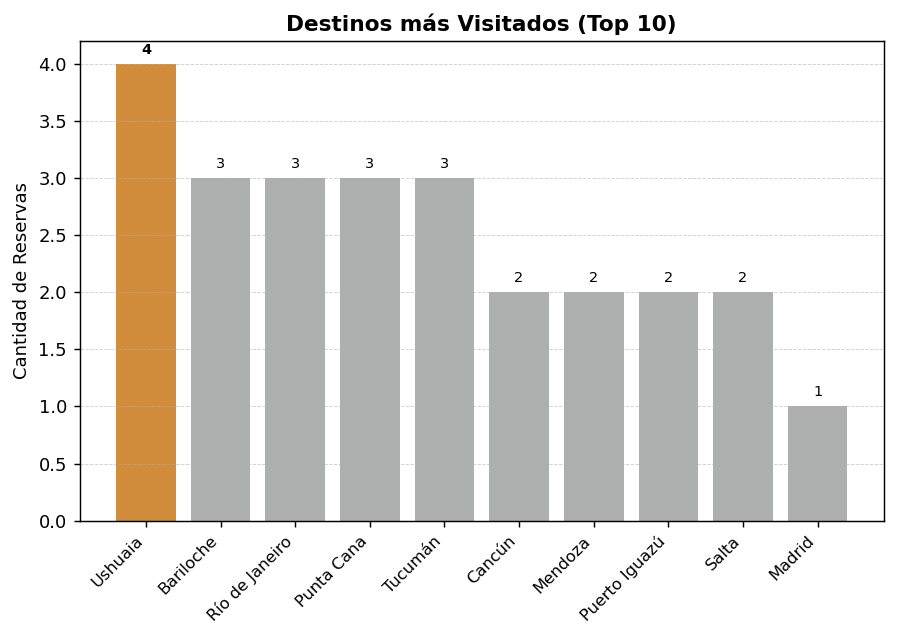

In [675]:
# ---------- 1) Destino más visitado ----------

# Usamos Neo4j contando relaciones VISITO por destino.

def calcular_destinos_mas_visitados(top_n=10):
    q = """
        MATCH (u:Usuario)-[:VISITO]->(d:Destino)
        RETURN d.destino_id AS destino_id, d.ciudad AS ciudad, count(u) AS cantidad
        ORDER BY cantidad DESC
        """
    with neo4j_driver.session() as s:
        res = s.run(q)
        destinos_agg = [{"_id": r["destino_id"], "cantidad": r["cantidad"], "ciudad": r["ciudad"]} for r in res]

    df = pd.DataFrame([{"destino_id": d["_id"], "ciudad": d.get("ciudad", f"destino_{d['_id']}"), "cantidad": d["cantidad"]} for d in destinos_agg])
    df = df.sort_values("cantidad", ascending=False).head(top_n).reset_index(drop=True)

    return df

df_destinos = calcular_destinos_mas_visitados(top_n=10)

# ---------- 1.A Gráfico: barra (conteo por destino) ----------
if not df_destinos.empty:
    # Aseguramos que el DataFrame esté limitado al Top 10 y ordenado
    df_destinos_plot = df_destinos.sort_values(by="cantidad", ascending=False).head(10)

    # 1. Definir Colores de Destaque
    color_base_pastel = "#AEB0B0"   # Gris Azulado Pastel
    color_destaque_pastel = "#D18C3C" # Rosa Pastel (para el más visitado)
    
    # Crear la lista de colores: todo con el base, excepto el índice 0 (el más visitado)
    colores = [color_base_pastel] * len(df_destinos_plot)
    colores[0] = color_destaque_pastel
    
    # Mostrar el mensaje de destaque
    destino_top = df_destinos_plot.loc[df_destinos_plot.index[0], "ciudad"]
    visitas_top = df_destinos_plot.loc[df_destinos_plot.index[0], "cantidad"]
    print(f"✅ El destino más visitado es **{destino_top}**, con {visitas_top:,} reservas.")

    plt.figure(figsize=(7, 5), dpi=130)
    
    # 2. Generar el gráfico de barras usando la lista de colores
    bars = plt.bar(df_destinos_plot["ciudad"], df_destinos_plot["cantidad"], color=colores)
    
    # 3. Añadir etiquetas de datos
    for i, rect in enumerate(bars):
        height = rect.get_height()
        # Muestra el valor con separador de miles
        plt.annotate(f"{int(height):,}",
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 4), 
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8,
                     # Negrita para el destino más visitado (índice 0)
                     fontweight='bold' if i == 0 else 'normal') 
        
    plt.xticks(rotation=45, ha="right", size=9)
    plt.ylabel("Cantidad de Reservas", size=10)
    
    plt.title(f"Destinos más Visitados (Top {len(df_destinos_plot)})", size=12, fontweight='bold')
    
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    
    plt.tight_layout()
    plt.show()


✅ El hotel más económico es Altos del Norte. Valor Base = $60,000. Se encuentra en la ciudad de Salta.


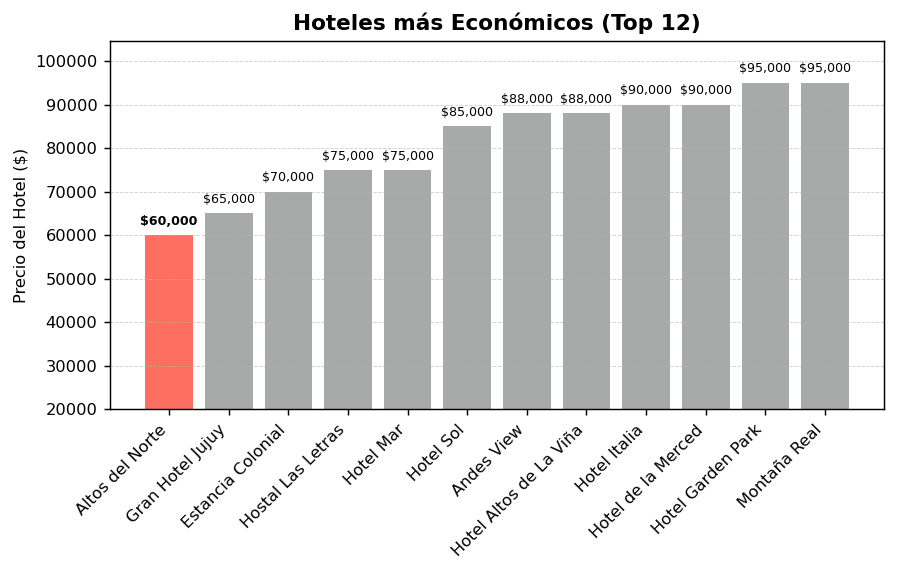

In [676]:
# ---------- 2) Hotel más barato ----------
# Buscamos el hotel con menor precio en la colección 'hoteles' de MongoDB
def obtener_hotel_mas_barato(top_n):
    # Obtengo los hoteles ordenados por precio ascendente, limitando a top_n
    cursor = db.hoteles.find(
        {}, {"_id":0, "hotel_id":1, "nombre":1, "destino_id":1, "precio":1}
    ).sort("precio", 1).limit(top_n)
    docs = list(cursor)
    if not docs:
        return pd.DataFrame()
    df = pd.DataFrame(docs)
    return df

df_hoteles_baratos = obtener_hotel_mas_barato(top_n=12)

# ---------- 2.A Gráfico: barras (hoteles, destacar el más barato) ----------
if df_hoteles_baratos.empty:
    print("⚠️ No hay datos de hoteles para graficar.")
else:
    # 1. Localizar el más barato y su ciudad
    idx_min = df_hoteles_baratos["precio"].idxmin()
    min_hotel = df_hoteles_baratos.loc[idx_min, "nombre"]
    min_precio = df_hoteles_baratos.loc[idx_min, "precio"]
    min_id = df_hoteles_baratos.loc[idx_min, "destino_id"]

    ciudad_nombre = DESTINO_ID_A_CIUDAD.get(min_id, "Desconocida") 
    
    print(f"✅ El hotel más económico es {min_hotel}. Valor Base = ${min_precio:,.0f}. Se encuentra en la ciudad de {ciudad_nombre}.")

    # 2. Crear figura más compacta
    plt.figure(figsize=(7, 4.5), dpi=130)
    
    # 3. Definir colores: destacar el más barato
    colores = np.array(["#A8A9A9"] * len(df_hoteles_baratos))  # Azul pastel claro
    colores[idx_min] = '#FF6F61'  # Rojo coral para el más barato

    # 4. Crear gráfico de barras
    bars = plt.bar(df_hoteles_baratos["nombre"], df_hoteles_baratos["precio"], color=colores)
    
    # 5. Etiquetas de precios encima de cada barra
    for i, rect in enumerate(bars):
        h = rect.get_height()
        plt.annotate(f"${int(h):,}",
                     xy=(rect.get_x() + rect.get_width()/2, h),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha="center", va="bottom",
                     fontsize=7,
                     fontweight='bold' if i == idx_min else 'normal')

    # 🔹 Ajustar eje Y para que empiece en 20.000
    y_min = 20000
    y_max = df_hoteles_baratos["precio"].max() * 1.1 
    plt.ylim(y_min, y_max)

    # 6. Etiquetas y estética
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.ylabel("Precio del Hotel ($)", size=9)
    plt.title(f"Hoteles más Económicos (Top {len(df_hoteles_baratos)})", size=12, fontweight='bold')
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

✅ La actividad más popular es **Tren del Fin del Mundo**. Cantidad de Reservas = **4**.


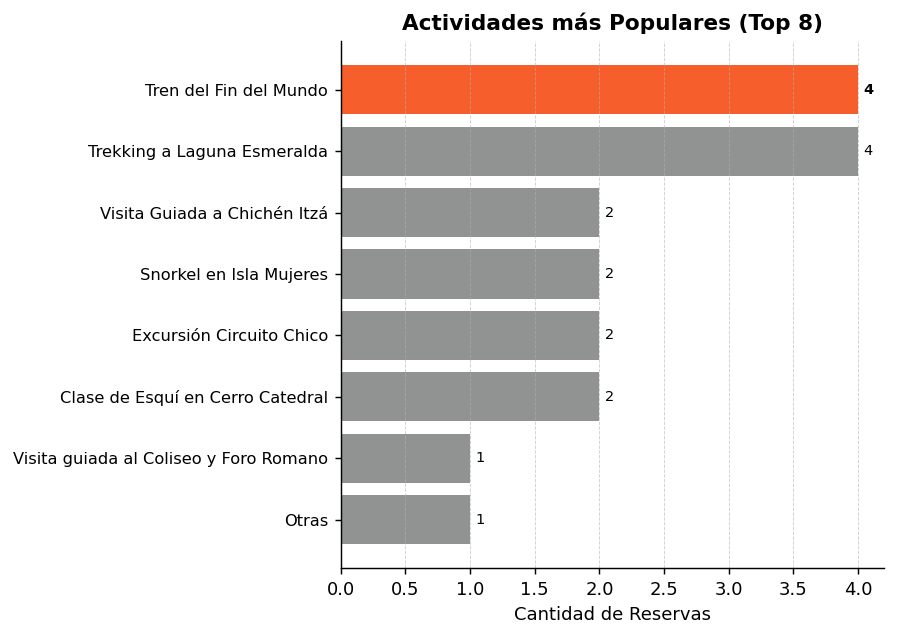

In [677]:
def calcular_actividad_mas_popular():
    """Calcula la popularidad de actividades contando las reservas a partir del array 'actividades_ids' en la colección 'reservas' (MongoDB)."""
    
    pipeline = [
        # 1. Desplegar el array: crea un documento por cada actividad_id
        {"$unwind": "$actividades_ids"}, 
        # 2. Agrupar por la actividad (ahora expuesta) y contar
        {"$group": {"_id": "$actividades_ids", "cantidad": {"$sum": 1}}},
        # 3. Ordenar
        {"$sort": {"cantidad": -1}}
    ]
    
    # Ejecutar la agregación
    agg = list(db.reservas.aggregate(pipeline)) 
    
    if not agg:
        return pd.DataFrame()
    actividades_map = {
        a["actividad_id"]: a["nombre"] 
        for a in db.actividades.find({}, {"_id":0,"actividad_id":1,"nombre":1})
    }
    
    df = pd.DataFrame([{
        "actividad_id": a["_id"],
        "cantidad": a["cantidad"],
        "nombre": actividades_map.get(a["_id"], f"act_{a['_id']}")
    } for a in agg])
    
    return df[['actividad_id', 'nombre', 'cantidad']]

df_actividades_pop = calcular_actividad_mas_popular()

# ---------- Gráfico: barras horizontales (actividades más populares) ----------
valores = df_actividades_pop["cantidad"].astype(int)
etiquetas = df_actividades_pop["nombre"]

# --- 1. Lógica de Agrupación 
top_k = 7 
valores_top = valores[:top_k]
etiquetas_top = etiquetas[:top_k]
    
indice_a_destacar = 0
    
if len(valores) > top_k:
    restantes_sum = valores[top_k:].sum()
    if restantes_sum > 0:
        etiquetas = etiquetas_top.tolist() + ["Otras"]
        valores = valores_top.tolist() + [restantes_sum]
    else: 
        etiquetas, valores = etiquetas_top, valores_top
else:
    etiquetas, valores = etiquetas_top, valores_top

# La actividad más popular es la primera fila (índice 0)
actividad_mas_popular = df_actividades_pop.loc[0, "nombre"]
cantidad_reservas = df_actividades_pop.loc[0, "cantidad"]
   
# 2. Definición de Colores
color_base_pastel = "#919393"  
color_destaque_pastel = "#F65E2C" 
   
# Inicializar todos los colores con el color base
colores_personalizados = [color_base_pastel] * len(valores)
colores_personalizados[indice_a_destacar] = color_destaque_pastel
   
# Invertir el orden para que la más popular quede arriba en el gráfico barh
valores.reverse()
etiquetas.reverse()
colores_personalizados.reverse()
 
print(f"✅ La actividad más popular es **{actividad_mas_popular}**. Cantidad de Reservas = **{cantidad_reservas:,}**.")
    
# --- 3. Gráfico de Barras Horizontal (MEJORA DE VISUALIZACIÓN) ---
plt.figure(figsize=(7, 5), dpi=130)
    
# Generar el gráfico de barras horizontales
bars = plt.barh(etiquetas, valores, color=colores_personalizados)
    
# Etiquetas de datos y formato
for i, bar in enumerate(bars):
    # Etiquetas de valor absoluto con formato de miles
    plt.text(bar.get_width()  + np.max(valores) * 0.01, 
        bar.get_y() + bar.get_height()/2, 
        f"{valores[i]:,}", 
        va='center', 
        fontsize=8,
     fontweight='bold' if i == len(valores) - 1 else 'normal') # La barra más popular está al final de la lista invertida
        
plt.xlabel("Cantidad de Reservas", size=10)
plt.title(f"Actividades más Populares (Top {len(etiquetas)})", fontsize=12, fontweight='bold', loc = "center")
   
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# PARTE D: Realizar modificación en los datos

    - Incrementar el precio de las actividades de Tucuman en 5% 
    - Agregar al hotel id=1 el servicio de SPA 
    - Eliminar el destino que desee 
    - Eliminar un usuario que desee 
    - Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

### 🧩 Modificaciones en los datos

Esta parte se dedica a **modificar o actualizar información existente** en la base de datos.  
Las modificaciones pueden involucrar cambios en los datos de destinos, reservas o usuarios.  

👉 Esta sección demuestra la capacidad del sistema para **adaptarse a nuevos datos y mantener la coherencia** entre MongoDB y Neo4j.


## Funciones para modificaciones

In [678]:
def eliminar_usuario(nombre: str):
    """Eliminar un usuario de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    print(f"\n🧹 --- Eliminando Usuario '{nombre}' ---")

    # --- Neo4j ---
    try:
        q = "MATCH (u:Usuario {nombre:$nombre}) DETACH DELETE u"
        query_neo4j(q, {"nombre": nombre})
        print(f"✅ Usuario '{nombre}' eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en Neo4j: {e}")

    # --- MongoDB ---
    try:
        res = db.usuarios.delete_one({"nombre": nombre})
        if res.deleted_count:
            print(f"✅ Usuario '{nombre}' eliminado de MongoDB (Colección Usuarios).")
        else:
            print(f"⚠️ Usuario '{nombre}' no encontrado en MongoDB.")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en MongoDB: {e}")


def eliminar_relaciones_amigo_de(nombre_usuario: str):
    """Eliminar todas las relaciones AMIGO_DE para un usuario específico (Neo4j)."""
    print(f"\n🔗 --- Eliminando relaciones AMIGO_DE de '{nombre_usuario}' ---")

    try:
        q = """
        MATCH (u:Usuario {nombre: $nombre_usuario})-[r:AMIGO_DE]-() 
        DELETE r
        """
        query_neo4j(q, {"nombre_usuario": nombre_usuario})
        print(f"✅ Todas las relaciones AMIGO_DE de '{nombre_usuario}' han sido eliminadas (Neo4j).")
    except Exception as e:
        print(f"❌ Error al eliminar relaciones AMIGO_DE en Neo4j: {e}")


def eliminar_destino(destino_id: int):
    """Eliminar un destino de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    print(f"\n🌍 --- Eliminando Destino ID {destino_id} ---")

    # --- Neo4j ---
    try:
        q = "MATCH (d:Destino {destino_id:$destino_id}) DETACH DELETE d"
        query_neo4j(q, {"destino_id": destino_id})
        print(f"✅ Destino ID {destino_id} eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar destino en Neo4j: {e}")

    # --- MongoDB ---
    try:
        db.hoteles.delete_many({"destino_id": destino_id})
        db.destinos.delete_one({"destino_id": destino_id})
        print(f"✅ Destino ID {destino_id} y hoteles asociados eliminados de MongoDB.")
    except Exception as e:
        print(f"❌ Error al eliminar destino en MongoDB: {e}")


def agregar_servicio_hotel(hotel_id: int, servicio: str):
    """Agregar un servicio a un hotel (MongoDB). Usa $addToSet para evitar duplicados."""
    print(f"\n🏨 --- Agregando servicio '{servicio}' al hotel {hotel_id} ---")

    try:
        res = db.hoteles.update_one(
            {"hotel_id": hotel_id},
            {"$addToSet": {"servicios": servicio}}
        )
        if res.modified_count:
            print(f"✅ Servicio '{servicio}' agregado al hotel {hotel_id} (MongoDB).")
        else:
            print(f"⚠️ No se modificó el hotel {hotel_id} (puede que ya tenga el servicio).")
    except Exception as e:
        print(f"❌ Error al agregar servicio en MongoDB: {e}")


def modificar_precio_actividades(ciudad: str, pct: float):
    """Incrementar precio de actividades en una ciudad por un porcentaje (MongoDB)."""
    print(f"\n💰 --- Modificando precios de actividades en {ciudad} ---")

    try:
        res = db.actividades.update_many(
            {"ciudad": ciudad},
            {"$mul": {"precio": 1 + pct}}
        )
        print(f"✅ Incrementadas {res.modified_count} actividades en {ciudad} en un {pct*100:.1f}%. (MongoDB)")
    except Exception as e:
        print(f"❌ Error al modificar precios en MongoDB: {e}")

## Pruebas

### 🧪 Pruebas de las modificaciones realizadas

Luego de ejecutar las modificaciones, se realizan pruebas para confirmar que los cambios fueron aplicados correctamente.  
Se consultan nuevamente las bases para verificar la persistencia de los datos actualizados y su reflejo en los resultados del sistema.

👉 Estas pruebas son esenciales para **validar la integridad de la información** después de operaciones de escritura o actualización.


In [679]:
# Ejecución de Modificaciones
print("\n--- Modificaciones ---\n")

# a. Incrementar el precio de las actividades de Bariloche en 5%
modificar_precio_actividades("Bariloche", 0.05) 

# b. Agregar al hotel id=1 el servicio de SPA
agregar_servicio_hotel(hotel_id=1, servicio="SPA")

# c. Eliminar el destino que desee (Ejemplo: ID 5)
eliminar_destino(destino_id=5)

# d. Eliminar un usuario que desee (Ejemplo: Lucía Godoy"")
eliminar_usuario("Lucía Godoy")

# e. Eliminar las relaciones AMIGO_DE para un usuario que quiera (Ejemplo: "María García")
eliminar_relaciones_amigo_de("María García")


--- Modificaciones ---


💰 --- Modificando precios de actividades en Bariloche ---
✅ Incrementadas 4 actividades en Bariloche en un 5.0%. (MongoDB)

🏨 --- Agregando servicio 'SPA' al hotel 1 ---
✅ Servicio 'SPA' agregado al hotel 1 (MongoDB).

🌍 --- Eliminando Destino ID 5 ---
✅ Destino ID 5 eliminado de Neo4j (Nodos y Relaciones).
✅ Destino ID 5 y hoteles asociados eliminados de MongoDB.

🧹 --- Eliminando Usuario 'Lucía Godoy' ---
✅ Usuario 'Lucía Godoy' eliminado de Neo4j (Nodos y Relaciones).
✅ Usuario 'Lucía Godoy' eliminado de MongoDB (Colección Usuarios).

🔗 --- Eliminando relaciones AMIGO_DE de 'María García' ---
✅ Todas las relaciones AMIGO_DE de 'María García' han sido eliminadas (Neo4j).


## PARTE F. Cierre de Conexiones
    Se cierran las conexiones a las bases de datos.

### 🔒 Finalización del entorno

En el bloque final se cierran las conexiones con las bases de datos MongoDB y Neo4j,  
asegurando la liberación adecuada de recursos y la finalización ordenada de las sesiones activas.  

👉 Este cierre controlado garantiza la **seguridad y estabilidad del entorno de ejecución**, evitando errores o bloqueos en futuras ejecuciones.


In [680]:
if neo4j_driver:
    neo4j_driver.close()
if mongo_client:
    mongo_client.close()
if redis_client:
    redis_client.close()
print("🔒 Conexiones cerradas correctamente.")

🔒 Conexiones cerradas correctamente.
